In [1]:
import pandas as pd
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler

# load packages
import pandas as pd
from typing import Optional
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import os

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape
from datetime import date
import logging as log
from models.dataset import Dataset as Dataset

from models.utils import add_horizons, normalize,normalize_apply,normalize_train,ad_normalize,normalize_by_prev_day
from models.gd import GradientDescent as GradientDescent
import random

In [2]:
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)                # for GPU
    torch.cuda.manual_seed_all(seed)            # for multi-GPU

    # Make cuDNN deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(50)

In [3]:
# parameters
tickers="slv"
#tickers="slv,"
#tickers=("slv",)
iteration_no=6
model_shortname="slv"
#0-> 10, 1->50,2->100
horizon_mapping = {
    0: 10,
    1: 50,
    2: 100
}
horizon_to_predict=2
look_back_window=100
batch_size=64
alpha=0.01

In [4]:
model_checkpoint_loc=f"/results/iteration{iteration_no}"
logs_loc=f"results/iteration{iteration_no}"
os.makedirs(f".{model_checkpoint_loc}", exist_ok=True)
tickers = tuple(x.strip() for x in tickers.split(","))
print(f"Running model with params Ticker: {tickers} Horizon Idx:{horizon_to_predict} window:{look_back_window} training batch size:{batch_size} alpha {alpha} iteration {iteration_no}")

Running model with params Ticker: ('slv',) Horizon Idx:2 window:100 training batch size:64 alpha 0.01 iteration 6


In [5]:
# Configure basic logging to a file
log.basicConfig(
    filename=f"{logs_loc}/experiments.log",  # Name of the log file
    level=log.INFO,             # Minimum logging level to capture (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of the log messages
    datefmt='%Y-%m-%d %H:%M:%S'      # Format for the timestamp
)

In [6]:
data_path="/home/nnagarajan/github/DNNLOB-FA800/data/etf/jan2025/cleaned/"
prefix="_cleaned_jan2025"

In [7]:
for ticker in tickers:
    log.info(f"Processing {ticker}")
    print(f"Processing {ticker}")
    dataset_train: Optional[Dataset] = None
    dataset_val: Optional[Dataset] = None
    dataset_test: Optional[Dataset] = None
    df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
    print(df.describe())
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")
    df=add_horizons(df,(10, 50, 100),alpha)
    class_summary = df.groupby(f"Target_{horizon_mapping[horizon_to_predict]}").size().reset_index(name="Count")
    # Calculate relative percentage
    class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
    class_summary["Percent"] = class_summary["Percent"].round(2)
    print(class_summary)
    #df=ad_normalize(df,100)
    normalize(df)
    #normalize_by_prev_day(df)
    df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
    df.groupby(["Date"]).size()
    df_train = df[(df["Date"] >= date(2025, 1, 3)) & (df["Date"] <= date(2025, 1, 24))]
    df_val = df[(df["Date"] >= date(2025, 1, 25)) & (df["Date"] <= date(2025, 1, 27))]
    df_test = df[(df["Date"] >= date(2025, 1, 28)) & (df["Date"] <= date(2025, 1, 30))]
    #df_train, scaler = normalize_train(df_train)
    #df_val = normalize_apply(df_val,scaler)
    #df_test = normalize_apply(df_test,scaler)
    target_cols = [f"Target_{i}" for i in [10, 50, 100]]
    price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
    size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]
    df_train = df_train[price_cols + size_cols +target_cols]
    df_val = df_val[price_cols + size_cols +target_cols]
    df_test =  df_test[price_cols + size_cols +target_cols]
    if None in (dataset_train, dataset_val, dataset_test):
        dataset_train = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val = Dataset(data=df_val.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
    else:
        dataset_train1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val1 = Dataset(data=df_val.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test1 = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_train.merge(dataset_train1)
        dataset_val.merge(dataset_val1)
        dataset_test.merge(dataset_test1)

Processing slv
          rel.spread     abs.spread      mid_price    L1-BidPrice  \
count  105069.000000  105069.000000  105069.000000  105069.000000   
mean        0.000563       0.015640      27.774061      27.766241   
std         0.001042       0.029019       0.483446       0.483648   
min         0.000346       0.010000      26.870000      26.800000   
25%         0.000360       0.010000      27.425000      27.420000   
50%         0.000368       0.010000      27.695000      27.690000   
75%         0.000720       0.020000      28.020000      28.010000   
max         0.035436       1.000000      28.895000      28.890000   

          L1-BidSize    L1-AskPrice     L1-AskSize    L2-BidPrice  \
count  105069.000000  105069.000000  105069.000000  105069.000000   
mean     5450.770418      27.781880    5535.321113      27.756143   
std      4665.433035       0.483679    4802.953373       0.483688   
min         1.000000      26.880000       1.000000      26.540000   
25%      1700.0000

In [8]:
df_train.head(1)

,L1-BidPrice,L2-BidPrice,L3-BidPrice,L4-BidPrice,L5-BidPrice,L6-BidPrice,L7-BidPrice,L8-BidPrice,L9-BidPrice,L10-BidPrice,...,L4-AskSize,L5-AskSize,L6-AskSize,L7-AskSize,L8-AskSize,L9-AskSize,L10-AskSize,Target_10,Target_50,Target_100
199,0.177033,0.264957,0.314741,0.390071,0.396491,0.428571,0.477204,0.511364,0.543767,0.808889,...,0.582867,0.603299,0.781909,0.468248,0.297789,0.205298,0.217926,1,0,1


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)
print(dataset_val.x.shape, dataset_val.y.shape)
print(dataset_test.x.shape, dataset_test.y.shape)

torch.Size([69728, 1, 100, 40]) torch.Size([69728])
torch.Size([4222, 1, 100, 40]) torch.Size([4222])
torch.Size([20249, 1, 100, 40]) torch.Size([20249])


In [ ]:
from models.deeplob import deeplob as deeplob
model = deeplob(device=device,y_len = dataset_train.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_deeplob.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from models.gd import GradientDescent as GradientDescent
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

  2%|▏         | 1/50 [00:09<07:56,  9.72s/it]

model saved
Epoch 1/50, Train Loss: 0.9766,               Validation Loss: 0.9733, Duration: 0:00:09.714652, Best Val Epoch: 0


  4%|▍         | 2/50 [00:18<07:25,  9.29s/it]

model saved
Epoch 2/50, Train Loss: 0.8681,               Validation Loss: 0.9569, Duration: 0:00:08.992161, Best Val Epoch: 1


  6%|▌         | 3/50 [00:27<07:10,  9.17s/it]

Epoch 3/50, Train Loss: 0.8198,               Validation Loss: 1.0088, Duration: 0:00:09.023298, Best Val Epoch: 1


  8%|▊         | 4/50 [00:35<06:35,  8.61s/it]

Epoch 4/50, Train Loss: 0.8001,               Validation Loss: 0.9818, Duration: 0:00:07.741978, Best Val Epoch: 1


 10%|█         | 5/50 [00:44<06:37,  8.82s/it]

Epoch 5/50, Train Loss: 0.8306,               Validation Loss: 0.9925, Duration: 0:00:09.209616, Best Val Epoch: 1


 12%|█▏        | 6/50 [00:53<06:24,  8.73s/it]

Epoch 6/50, Train Loss: 0.7888,               Validation Loss: 0.9624, Duration: 0:00:08.553592, Best Val Epoch: 1


 14%|█▍        | 7/50 [01:02<06:21,  8.88s/it]

model saved
Epoch 7/50, Train Loss: 0.7723,               Validation Loss: 0.9062, Duration: 0:00:09.188904, Best Val Epoch: 6


 16%|█▌        | 8/50 [01:12<06:24,  9.16s/it]

model saved
Epoch 8/50, Train Loss: 0.7800,               Validation Loss: 0.9059, Duration: 0:00:09.741568, Best Val Epoch: 7


 18%|█▊        | 9/50 [01:20<06:07,  8.98s/it]

Epoch 9/50, Train Loss: 0.8197,               Validation Loss: 0.9327, Duration: 0:00:08.578194, Best Val Epoch: 7


 20%|██        | 10/50 [01:30<06:04,  9.11s/it]

Epoch 10/50, Train Loss: 0.8020,               Validation Loss: 1.0007, Duration: 0:00:09.424185, Best Val Epoch: 7


  2%|▏         | 1/50 [00:02<02:00,  2.47s/it]

model saved
Epoch 1/50, Train Loss: 0.9478,               Validation Loss: 0.9026, Duration: 0:00:02.467006, Best Val Epoch: 0


  4%|▍         | 2/50 [00:05<02:00,  2.52s/it]

Epoch 2/50, Train Loss: 0.8442,               Validation Loss: 0.9192, Duration: 0:00:02.554903, Best Val Epoch: 0


  6%|▌         | 3/50 [00:07<02:03,  2.64s/it]

Epoch 3/50, Train Loss: 0.8239,               Validation Loss: 1.0007, Duration: 0:00:02.773511, Best Val Epoch: 0


  8%|▊         | 4/50 [00:10<02:00,  2.62s/it]

Epoch 4/50, Train Loss: 0.8095,               Validation Loss: 1.0026, Duration: 0:00:02.599862, Best Val Epoch: 0


 10%|█         | 5/50 [00:13<01:59,  2.66s/it]

Epoch 5/50, Train Loss: 0.7978,               Validation Loss: 1.0267, Duration: 0:00:02.726523, Best Val Epoch: 0


 12%|█▏        | 6/50 [00:15<01:57,  2.68s/it]

Epoch 6/50, Train Loss: 0.7834,               Validation Loss: 1.0577, Duration: 0:00:02.712209, Best Val Epoch: 0


 14%|█▍        | 7/50 [00:18<01:56,  2.70s/it]

Epoch 7/50, Train Loss: 0.7678,               Validation Loss: 1.0840, Duration: 0:00:02.748345, Best Val Epoch: 0


 16%|█▌        | 8/50 [00:21<01:53,  2.70s/it]

Epoch 8/50, Train Loss: 0.7541,               Validation Loss: 1.0993, Duration: 0:00:02.692188, Best Val Epoch: 0


 18%|█▊        | 9/50 [00:23<01:49,  2.68s/it]

Epoch 9/50, Train Loss: 0.7370,               Validation Loss: 1.0566, Duration: 0:00:02.626526, Best Val Epoch: 0


 20%|██        | 10/50 [00:26<01:47,  2.69s/it]

Epoch 10/50, Train Loss: 0.7238,               Validation Loss: 1.0538, Duration: 0:00:02.717964, Best Val Epoch: 0


 22%|██▏       | 11/50 [00:29<01:44,  2.69s/it]

Epoch 11/50, Train Loss: 0.7109,               Validation Loss: 1.0516, Duration: 0:00:02.680211, Best Val Epoch: 0


 24%|██▍       | 12/50 [00:32<01:47,  2.83s/it]

Epoch 12/50, Train Loss: 0.7007,               Validation Loss: 0.9975, Duration: 0:00:03.167744, Best Val Epoch: 0


 26%|██▌       | 13/50 [00:35<01:46,  2.87s/it]

Epoch 13/50, Train Loss: 0.6885,               Validation Loss: 0.9897, Duration: 0:00:02.948166, Best Val Epoch: 0


 28%|██▊       | 14/50 [00:38<01:41,  2.82s/it]

Epoch 14/50, Train Loss: 0.6779,               Validation Loss: 1.0374, Duration: 0:00:02.691693, Best Val Epoch: 0


 30%|███       | 15/50 [00:40<01:37,  2.79s/it]

Epoch 15/50, Train Loss: 0.6682,               Validation Loss: 0.9650, Duration: 0:00:02.735774, Best Val Epoch: 0


 32%|███▏      | 16/50 [00:43<01:35,  2.82s/it]

Epoch 16/50, Train Loss: 0.6559,               Validation Loss: 0.9096, Duration: 0:00:02.883380, Best Val Epoch: 0


 34%|███▍      | 17/50 [00:46<01:33,  2.82s/it]

Epoch 17/50, Train Loss: 0.6475,               Validation Loss: 0.9561, Duration: 0:00:02.817614, Best Val Epoch: 0


 36%|███▌      | 18/50 [00:49<01:30,  2.82s/it]

model saved
Epoch 18/50, Train Loss: 0.6380,               Validation Loss: 0.8779, Duration: 0:00:02.809119, Best Val Epoch: 17


 38%|███▊      | 19/50 [00:52<01:27,  2.81s/it]

Epoch 19/50, Train Loss: 0.6294,               Validation Loss: 0.8915, Duration: 0:00:02.786296, Best Val Epoch: 17


 40%|████      | 20/50 [00:54<01:24,  2.80s/it]

Epoch 20/50, Train Loss: 0.6192,               Validation Loss: 0.8941, Duration: 0:00:02.792035, Best Val Epoch: 17


 42%|████▏     | 21/50 [00:57<01:21,  2.82s/it]

Epoch 21/50, Train Loss: 0.6142,               Validation Loss: 0.8939, Duration: 0:00:02.866031, Best Val Epoch: 17


 44%|████▍     | 22/50 [01:00<01:19,  2.84s/it]

model saved
Epoch 22/50, Train Loss: 0.6063,               Validation Loss: 0.8398, Duration: 0:00:02.872592, Best Val Epoch: 21


 46%|████▌     | 23/50 [01:03<01:20,  2.97s/it]

model saved
Epoch 23/50, Train Loss: 0.5967,               Validation Loss: 0.8178, Duration: 0:00:03.288961, Best Val Epoch: 22


 48%|████▊     | 24/50 [01:06<01:15,  2.92s/it]

model saved
Epoch 24/50, Train Loss: 0.5894,               Validation Loss: 0.8046, Duration: 0:00:02.781960, Best Val Epoch: 23


 50%|█████     | 25/50 [01:09<01:08,  2.74s/it]

Epoch 25/50, Train Loss: 0.5826,               Validation Loss: 0.8271, Duration: 0:00:02.322353, Best Val Epoch: 23


 52%|█████▏    | 26/50 [01:11<01:05,  2.72s/it]

Epoch 26/50, Train Loss: 0.5779,               Validation Loss: 0.8231, Duration: 0:00:02.687146, Best Val Epoch: 23


 54%|█████▍    | 27/50 [01:14<01:03,  2.75s/it]

model saved
Epoch 27/50, Train Loss: 0.5725,               Validation Loss: 0.7574, Duration: 0:00:02.809847, Best Val Epoch: 26


 56%|█████▌    | 28/50 [01:17<01:01,  2.78s/it]

Epoch 28/50, Train Loss: 0.5623,               Validation Loss: 0.8556, Duration: 0:00:02.857080, Best Val Epoch: 26


 58%|█████▊    | 29/50 [01:19<00:56,  2.69s/it]

Epoch 29/50, Train Loss: 0.5582,               Validation Loss: 0.7862, Duration: 0:00:02.474067, Best Val Epoch: 26


 60%|██████    | 30/50 [01:22<00:54,  2.73s/it]

Epoch 30/50, Train Loss: 0.5522,               Validation Loss: 0.7917, Duration: 0:00:02.816379, Best Val Epoch: 26


 62%|██████▏   | 31/50 [01:25<00:51,  2.71s/it]

Epoch 31/50, Train Loss: 0.5437,               Validation Loss: 0.8476, Duration: 0:00:02.665522, Best Val Epoch: 26


 64%|██████▍   | 32/50 [01:28<00:48,  2.69s/it]

Epoch 32/50, Train Loss: 0.5393,               Validation Loss: 0.8090, Duration: 0:00:02.639268, Best Val Epoch: 26


 66%|██████▌   | 33/50 [01:30<00:45,  2.70s/it]

Epoch 33/50, Train Loss: 0.5388,               Validation Loss: 0.7714, Duration: 0:00:02.737115, Best Val Epoch: 26


 68%|██████▊   | 34/50 [01:33<00:43,  2.70s/it]

Epoch 34/50, Train Loss: 0.5288,               Validation Loss: 0.7821, Duration: 0:00:02.695063, Best Val Epoch: 26


 70%|███████   | 35/50 [01:36<00:40,  2.73s/it]

Epoch 35/50, Train Loss: 0.5240,               Validation Loss: 0.8357, Duration: 0:00:02.804665, Best Val Epoch: 26


 72%|███████▏  | 36/50 [01:38<00:38,  2.73s/it]

Epoch 36/50, Train Loss: 0.5199,               Validation Loss: 0.8384, Duration: 0:00:02.707518, Best Val Epoch: 26


 74%|███████▍  | 37/50 [01:41<00:35,  2.72s/it]

Epoch 37/50, Train Loss: 0.5128,               Validation Loss: 0.8505, Duration: 0:00:02.710561, Best Val Epoch: 26


 76%|███████▌  | 38/50 [01:44<00:32,  2.67s/it]

Epoch 38/50, Train Loss: 0.5066,               Validation Loss: 0.7734, Duration: 0:00:02.559130, Best Val Epoch: 26


 78%|███████▊  | 39/50 [01:46<00:28,  2.58s/it]

Epoch 39/50, Train Loss: 0.5061,               Validation Loss: 0.8638, Duration: 0:00:02.363346, Best Val Epoch: 26


 80%|████████  | 40/50 [01:49<00:26,  2.63s/it]

Epoch 40/50, Train Loss: 0.5015,               Validation Loss: 0.8421, Duration: 0:00:02.739791, Best Val Epoch: 26


 82%|████████▏ | 41/50 [01:51<00:23,  2.62s/it]

Epoch 41/50, Train Loss: 0.4925,               Validation Loss: 0.8696, Duration: 0:00:02.607922, Best Val Epoch: 26


 84%|████████▍ | 42/50 [01:54<00:20,  2.60s/it]

Epoch 42/50, Train Loss: 0.4884,               Validation Loss: 0.8478, Duration: 0:00:02.547432, Best Val Epoch: 26


 86%|████████▌ | 43/50 [01:57<00:18,  2.63s/it]

Epoch 43/50, Train Loss: 0.4827,               Validation Loss: 0.8846, Duration: 0:00:02.689033, Best Val Epoch: 26


 88%|████████▊ | 44/50 [01:59<00:15,  2.66s/it]

Epoch 44/50, Train Loss: 0.4824,               Validation Loss: 0.8497, Duration: 0:00:02.751799, Best Val Epoch: 26


 90%|█████████ | 45/50 [02:02<00:13,  2.71s/it]

Epoch 45/50, Train Loss: 0.4779,               Validation Loss: 0.8511, Duration: 0:00:02.816940, Best Val Epoch: 26


 92%|█████████▏| 46/50 [02:05<00:10,  2.73s/it]

Epoch 46/50, Train Loss: 0.4738,               Validation Loss: 0.9123, Duration: 0:00:02.775725, Best Val Epoch: 26


 94%|█████████▍| 47/50 [02:07<00:07,  2.62s/it]

Epoch 47/50, Train Loss: 0.4678,               Validation Loss: 0.8588, Duration: 0:00:02.372224, Best Val Epoch: 26


 96%|█████████▌| 48/50 [02:10<00:05,  2.66s/it]

Epoch 48/50, Train Loss: 0.4647,               Validation Loss: 0.8466, Duration: 0:00:02.749190, Best Val Epoch: 26


 98%|█████████▊| 49/50 [02:12<00:02,  2.55s/it]

Epoch 49/50, Train Loss: 0.4612,               Validation Loss: 0.9113, Duration: 0:00:02.291072, Best Val Epoch: 26


100%|██████████| 50/50 [02:15<00:00,  2.71s/it]

Epoch 50/50, Train Loss: 0.4544,               Validation Loss: 0.8472, Duration: 0:00:02.687728, Best Val Epoch: 26


accuracy_score: 0.6219072546792435
              precision    recall  f1-score   support

           0     0.3993    0.1513    0.2194      4938
           1     0.6136    0.8740    0.7210      7213
           2     0.6838    0.6844    0.6841      8098

    accuracy                         0.6219     20249
   macro avg     0.5656    0.5699    0.5415     20249
weighted avg     0.5894    0.6219    0.5839     20249



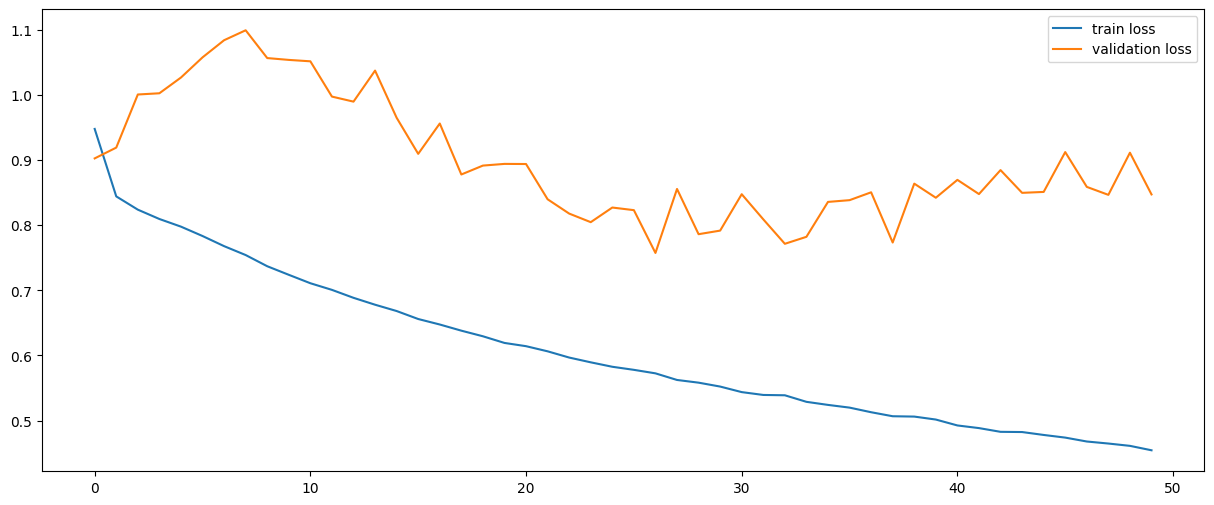

In [12]:
from models.cnn1 import CNN1

model = CNN1(num_classes = dataset_train.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_cnn1.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

  2%|▏         | 1/50 [00:01<01:28,  1.81s/it]

model saved
Epoch 1/50, Train Loss: 0.9725,               Validation Loss: 0.9122, Duration: 0:00:01.813081, Best Val Epoch: 0


  4%|▍         | 2/50 [00:03<01:27,  1.83s/it]

model saved
Epoch 2/50, Train Loss: 0.9157,               Validation Loss: 0.9110, Duration: 0:00:01.844033, Best Val Epoch: 1


  6%|▌         | 3/50 [00:05<01:25,  1.82s/it]

Epoch 3/50, Train Loss: 0.8954,               Validation Loss: 0.9136, Duration: 0:00:01.807602, Best Val Epoch: 1


  8%|▊         | 4/50 [00:07<01:23,  1.82s/it]

Epoch 4/50, Train Loss: 0.8832,               Validation Loss: 0.9200, Duration: 0:00:01.810739, Best Val Epoch: 1


 10%|█         | 5/50 [00:09<01:20,  1.79s/it]

model saved
Epoch 5/50, Train Loss: 0.8743,               Validation Loss: 0.9062, Duration: 0:00:01.729712, Best Val Epoch: 4


 12%|█▏        | 6/50 [00:10<01:19,  1.81s/it]

model saved
Epoch 6/50, Train Loss: 0.8690,               Validation Loss: 0.9047, Duration: 0:00:01.846128, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:12<01:18,  1.83s/it]

model saved
Epoch 7/50, Train Loss: 0.8630,               Validation Loss: 0.9026, Duration: 0:00:01.887095, Best Val Epoch: 6


 16%|█▌        | 8/50 [00:14<01:17,  1.84s/it]

Epoch 8/50, Train Loss: 0.8584,               Validation Loss: 0.9317, Duration: 0:00:01.864494, Best Val Epoch: 6


 18%|█▊        | 9/50 [00:16<01:15,  1.84s/it]

Epoch 9/50, Train Loss: 0.8555,               Validation Loss: 0.9223, Duration: 0:00:01.817745, Best Val Epoch: 6


 20%|██        | 10/50 [00:18<01:13,  1.83s/it]

Epoch 10/50, Train Loss: 0.8526,               Validation Loss: 0.9188, Duration: 0:00:01.808742, Best Val Epoch: 6


 22%|██▏       | 11/50 [00:20<01:11,  1.84s/it]

Epoch 11/50, Train Loss: 0.8477,               Validation Loss: 0.9235, Duration: 0:00:01.877127, Best Val Epoch: 6


 24%|██▍       | 12/50 [00:21<01:10,  1.86s/it]

Epoch 12/50, Train Loss: 0.8444,               Validation Loss: 0.9368, Duration: 0:00:01.882124, Best Val Epoch: 6


 26%|██▌       | 13/50 [00:24<01:11,  1.93s/it]

Epoch 13/50, Train Loss: 0.8429,               Validation Loss: 0.9380, Duration: 0:00:02.097109, Best Val Epoch: 6


 28%|██▊       | 14/50 [00:25<01:08,  1.91s/it]

Epoch 14/50, Train Loss: 0.8403,               Validation Loss: 0.9115, Duration: 0:00:01.875770, Best Val Epoch: 6


 30%|███       | 15/50 [00:27<01:05,  1.88s/it]

Epoch 15/50, Train Loss: 0.8360,               Validation Loss: 0.9151, Duration: 0:00:01.792001, Best Val Epoch: 6


 32%|███▏      | 16/50 [00:29<01:02,  1.85s/it]

model saved
Epoch 16/50, Train Loss: 0.8337,               Validation Loss: 0.9013, Duration: 0:00:01.792401, Best Val Epoch: 15


 34%|███▍      | 17/50 [00:31<01:04,  1.95s/it]

Epoch 17/50, Train Loss: 0.8306,               Validation Loss: 0.9252, Duration: 0:00:02.169327, Best Val Epoch: 15


 36%|███▌      | 18/50 [00:33<01:04,  2.03s/it]

Epoch 18/50, Train Loss: 0.8271,               Validation Loss: 0.9193, Duration: 0:00:02.217751, Best Val Epoch: 15


 38%|███▊      | 19/50 [00:35<01:01,  1.97s/it]

Epoch 19/50, Train Loss: 0.8256,               Validation Loss: 0.9072, Duration: 0:00:01.831518, Best Val Epoch: 15


 40%|████      | 20/50 [00:37<00:58,  1.94s/it]

Epoch 20/50, Train Loss: 0.8219,               Validation Loss: 0.9071, Duration: 0:00:01.879892, Best Val Epoch: 15


 42%|████▏     | 21/50 [00:39<00:55,  1.92s/it]

Epoch 21/50, Train Loss: 0.8199,               Validation Loss: 0.9106, Duration: 0:00:01.858917, Best Val Epoch: 15


 44%|████▍     | 22/50 [00:41<00:52,  1.89s/it]

Epoch 22/50, Train Loss: 0.8179,               Validation Loss: 0.9122, Duration: 0:00:01.832797, Best Val Epoch: 15


 46%|████▌     | 23/50 [00:43<00:51,  1.93s/it]

model saved
Epoch 23/50, Train Loss: 0.8153,               Validation Loss: 0.8946, Duration: 0:00:02.001707, Best Val Epoch: 22


 48%|████▊     | 24/50 [00:45<00:52,  2.03s/it]

model saved
Epoch 24/50, Train Loss: 0.8126,               Validation Loss: 0.8851, Duration: 0:00:02.273818, Best Val Epoch: 23


 50%|█████     | 25/50 [00:47<00:49,  2.00s/it]

Epoch 25/50, Train Loss: 0.8115,               Validation Loss: 0.9041, Duration: 0:00:01.914011, Best Val Epoch: 23


 52%|█████▏    | 26/50 [00:49<00:48,  2.00s/it]

Epoch 26/50, Train Loss: 0.8080,               Validation Loss: 0.9190, Duration: 0:00:02.011969, Best Val Epoch: 23


 54%|█████▍    | 27/50 [00:51<00:45,  1.96s/it]

Epoch 27/50, Train Loss: 0.8052,               Validation Loss: 0.9044, Duration: 0:00:01.865934, Best Val Epoch: 23


 56%|█████▌    | 28/50 [00:53<00:42,  1.91s/it]

Epoch 28/50, Train Loss: 0.8048,               Validation Loss: 0.8981, Duration: 0:00:01.802822, Best Val Epoch: 23


 58%|█████▊    | 29/50 [00:55<00:39,  1.89s/it]

Epoch 29/50, Train Loss: 0.8015,               Validation Loss: 0.9008, Duration: 0:00:01.847781, Best Val Epoch: 23


 60%|██████    | 30/50 [00:57<00:39,  2.00s/it]

Epoch 30/50, Train Loss: 0.7998,               Validation Loss: 0.9015, Duration: 0:00:02.230199, Best Val Epoch: 23


 62%|██████▏   | 31/50 [00:59<00:37,  1.97s/it]

Epoch 31/50, Train Loss: 0.7982,               Validation Loss: 0.8912, Duration: 0:00:01.915500, Best Val Epoch: 23


 64%|██████▍   | 32/50 [01:01<00:36,  2.05s/it]

model saved
Epoch 32/50, Train Loss: 0.7953,               Validation Loss: 0.8826, Duration: 0:00:02.245119, Best Val Epoch: 31


 66%|██████▌   | 33/50 [01:02<00:32,  1.89s/it]

model saved
Epoch 33/50, Train Loss: 0.7930,               Validation Loss: 0.8803, Duration: 0:00:01.491536, Best Val Epoch: 32


 68%|██████▊   | 34/50 [01:04<00:27,  1.73s/it]

model saved
Epoch 34/50, Train Loss: 0.7910,               Validation Loss: 0.8775, Duration: 0:00:01.370761, Best Val Epoch: 33


 70%|███████   | 35/50 [01:06<00:26,  1.75s/it]

Epoch 35/50, Train Loss: 0.7893,               Validation Loss: 0.8827, Duration: 0:00:01.777226, Best Val Epoch: 33


 72%|███████▏  | 36/50 [01:07<00:25,  1.79s/it]

Epoch 36/50, Train Loss: 0.7868,               Validation Loss: 0.8833, Duration: 0:00:01.884009, Best Val Epoch: 33


 74%|███████▍  | 37/50 [01:09<00:23,  1.81s/it]

Epoch 37/50, Train Loss: 0.7844,               Validation Loss: 0.8957, Duration: 0:00:01.870245, Best Val Epoch: 33


 76%|███████▌  | 38/50 [01:11<00:22,  1.83s/it]

model saved
Epoch 38/50, Train Loss: 0.7829,               Validation Loss: 0.8681, Duration: 0:00:01.883866, Best Val Epoch: 37


 78%|███████▊  | 39/50 [01:13<00:20,  1.84s/it]

Epoch 39/50, Train Loss: 0.7812,               Validation Loss: 0.8692, Duration: 0:00:01.851416, Best Val Epoch: 37


 80%|████████  | 40/50 [01:15<00:18,  1.87s/it]

Epoch 40/50, Train Loss: 0.7800,               Validation Loss: 0.8704, Duration: 0:00:01.951346, Best Val Epoch: 37


 82%|████████▏ | 41/50 [01:17<00:17,  1.91s/it]

Epoch 41/50, Train Loss: 0.7794,               Validation Loss: 0.8705, Duration: 0:00:02.010365, Best Val Epoch: 37


 84%|████████▍ | 42/50 [01:19<00:15,  1.98s/it]

Epoch 42/50, Train Loss: 0.7746,               Validation Loss: 0.8864, Duration: 0:00:02.132619, Best Val Epoch: 37


 86%|████████▌ | 43/50 [01:22<00:14,  2.09s/it]

Epoch 43/50, Train Loss: 0.7757,               Validation Loss: 0.8725, Duration: 0:00:02.354035, Best Val Epoch: 37


 88%|████████▊ | 44/50 [01:23<00:12,  2.04s/it]

model saved
Epoch 44/50, Train Loss: 0.7735,               Validation Loss: 0.8634, Duration: 0:00:01.923193, Best Val Epoch: 43


 90%|█████████ | 45/50 [01:25<00:10,  2.03s/it]

Epoch 45/50, Train Loss: 0.7711,               Validation Loss: 0.8685, Duration: 0:00:02.009236, Best Val Epoch: 43


 92%|█████████▏| 46/50 [01:27<00:07,  1.99s/it]

model saved
Epoch 46/50, Train Loss: 0.7707,               Validation Loss: 0.8547, Duration: 0:00:01.905403, Best Val Epoch: 45


 94%|█████████▍| 47/50 [01:30<00:06,  2.06s/it]

Epoch 47/50, Train Loss: 0.7693,               Validation Loss: 0.8644, Duration: 0:00:02.200758, Best Val Epoch: 45


 96%|█████████▌| 48/50 [01:31<00:03,  1.99s/it]

Epoch 48/50, Train Loss: 0.7679,               Validation Loss: 0.8548, Duration: 0:00:01.830648, Best Val Epoch: 45


 98%|█████████▊| 49/50 [01:33<00:01,  1.93s/it]

Epoch 49/50, Train Loss: 0.7664,               Validation Loss: 0.8696, Duration: 0:00:01.795103, Best Val Epoch: 45


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]

model saved
Epoch 50/50, Train Loss: 0.7649,               Validation Loss: 0.8547, Duration: 0:00:01.848530, Best Val Epoch: 49


accuracy_score: 0.5870907205294088
              precision    recall  f1-score   support

           0     0.3344    0.4727    0.3917      4938
           1     0.7307    0.5620    0.6354      7213
           2     0.7123    0.6792    0.6954      8098

    accuracy                         0.5871     20249
   macro avg     0.5925    0.5713    0.5741     20249
weighted avg     0.6267    0.5871    0.5999     20249



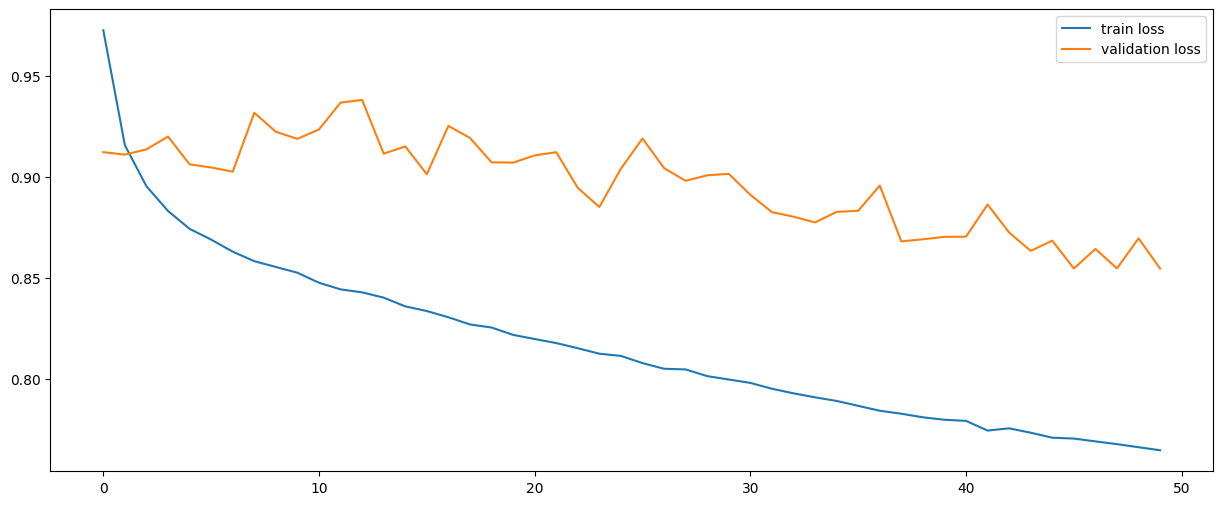

In [13]:
from models.mlp import MLP

model = MLP()
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_mlp.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))